# Capstone Project: Wine Recommender
---
Book 1: Problem Statement & Data Cleaning<br>
Book 2: Exploratory Data Analysis, Preprocessing & Feature Engineering<br>
**Book 3: Modelling, Conclusion & Recommendation**<br>
Author: Lee Wan Xian

## Contents:
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
- [Recommendation](#Recommendation)

## Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from collections import defaultdict

from random import sample, choice, seed

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, KFold, GridSearchCV
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, NMF, SlopeOne, CoClustering

In [2]:
# this setting widens pandas column to fit 400 characters
pd.options.display.max_colwidth = 400

## Modelling

### Model Preparation

In [3]:
# Import wine dataframes
df_wine_model = pd.read_pickle('../data/df_wine_us_rate.pkl')
df_wine_combi = pd.read_pickle('../data/df_wine_combi.pkl')

In [4]:
# Set the parameters for reader, data, algorithms, KFold strategy
kf = KFold(random_state=42)
reader = Reader(rating_scale=(88, 100))
data = Dataset.load_from_df(df_wine_model, reader)
algors = {
    'Normal Predictor': NormalPredictor(),
    'Baseline Predictor': BaselineOnly(),
    'KNN Basic': KNNBasic(),
    'KNN Means': KNNWithMeans(),
    'KNN ZScore': KNNWithZScore(),
    'KNN Baseline': KNNBaseline(),
    'SVD': SVD(random_state=42),
    'NonNegative Matrix Factorization': NMF(random_state=42),
    'Slope One': SlopeOne(),
    'Co-clustering': CoClustering(random_state=42)
}

In [5]:
# Create lists of unique wines & wine tasters
list_wines = df_wine_model['title'].unique().tolist()
list_tasters = df_wine_model['taster_name'].unique().tolist()

# Show unique count of wine & wine tasters
print(f'There are {len(list_wines)} unique wines in data')
print(f'There are {len(list_tasters)} unique tasters in data')

There are 15572 unique wines in data
There are 10 unique tasters in data


In our model dataset, we have 10 unique tasters, 15572 unique wines, and ratings given for each wine. Given that the dataset has explicit ratings, we can use [Scikit-Surprise](https://surpriselib.com/) library to train our recommender system model.<br>

Relevant wine definition: We will deem that relevant wines have a points rating of 90 and above. This is because the rating of 90 is right below the median point of our dataset and the recommender should recommend wines that are rated better than or equivalent to the median point.

### Baseline Model: Pure Randomized Recommender

In [6]:
# Create the baseline model & generate Precision@k and Recall@k results

k=10                # Represents the number of recommendations to return
precision = []      # Precision@k value list using random experiments
recall = []         # Recall@k value list using random experiments

for i in range(len(list_tasters)):
    seed(42)
    random_user = choice(list_tasters)
    relevant_wines = df_wine_model[(df_wine_model['taster_name']!=random_user) & (df_wine_model['points']>=90)]['title'].unique().tolist()
    count_relevant_wines = len(relevant_wines)
    
    # Since all titles can be selected for pure randomized recommender model, we select a random k titles
    random_10_wines = sample(list_wines, k)    
    rec_correct_wines = []
    for wine in random_10_wines:
        if wine in relevant_wines:
            rec_correct_wines.append(wine)

    if count_relevant_wines == 0:
        recall.append(0)
    else:
        recall.append(len(rec_correct_wines)/count_relevant_wines)
    
    precision.append(len(rec_correct_wines)/k)
    
    list_tasters.remove(random_user)

precision_at_k = sum(precision)/len(precision)
recall_at_k = sum(recall)/len(recall)

print(f'Average precision@k is {round(precision_at_k, 6)}')
print(f'Average recall@k is {round(recall_at_k, 6)}')

Average precision@k is 0.36
Average recall@k is 0.000364


Due to the nature of a randomized recommender model generating different recommendations in each run, the RMSE could range from $0$ to $\infty$. Thus, it is impossible to calculate a RMSE value with small variation.

### Other Model Algorithm Trials

The Surprise library provides an array of in-built [algorithms](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html) that can serve as the model for recommender system.<br>
For the purpose of this project, we will test out the below algorithms and choose the most suitable one based on Root Mean Squared Error (RMSE) and Precision@k.
1. `Baseline Predictor`: Basic algorithm predicting the baseline estimate for given user and item.
2. `Normal Predictor`: Basic algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
3. `KNN Basic`: A basic collaborative filtering k-NN based algorithm.
4. `KNN with Means`: A basic collaborative filtering k-NN based algorithm, taking into account the mean ratings of each user.
5. `KNN with Z score`: A basic collaborative filtering k-NN based algorithm, taking into account the z-score normalization of each user.
6. `KNN Baseline`: A basic collaborative filtering k-NN based algorithm taking into account a baseline rating.
7. `SVD`: The famous Singular Value Decomposition algorithm which is a Matrix Factorization based algorithm.
8. `NonNegative Matrix Factorization`: A collaborative filtering algorithm based on Non-negative Matrix Factorization.
9. `Slope One`: A simple yet accurate collaborative filtering algorithm.
10. `Co-clustering`: A collaborative filtering algorithm based on co-clustering.

RMSE is calculated based on comparing the predicted rating to the true rating for each taster-wine pair with a known label.

In [7]:
# Run multiple tests on algorithms list for RMSE results (Similarity used is Mean Squared Difference) 
msd_rmse_results = []

for algo_name, algo in tqdm(algors.items()):
    algo_results = []
    results = cross_validate(algo, data, measures=['rmse'], cv=kf, n_jobs=-1)
    algo_results.append(algo_name)
    algo_results.append(results['test_rmse'].mean())
    msd_rmse_results.append(algo_results)
    
# Generate the RMSE results for all algors in dataframe
msd_results_df = pd.DataFrame(msd_rmse_results, columns = ['algorithm_name', 'ave_rmse_score'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.84s/it]


The formula of Precision@k and Recall@k is based on this [documentation](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k). As stated earlier, we have set the threshold for defining relevant wines as those with ratings above or equal to 90. As for k, we will set it as 10 as it's expected that our recommender system is to recommend 10 wines.<br>
In simpler terms, Precision@k is the proportion of recommended wines in the top-k set that are relevant. The higher the Precision@k, the more relevant rated wines will appear in the recommendations. Recall@k is the proportion of relevant wines found in the top-k recommendations. It is hard to define the behaviour of Recall@k as it is susceptible to the number of relevant wines in the whole dataset.

In [8]:
# Function for calculating precision@k & recall@k (https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k)
def precision_recall_at_k(predictions, threshold, k=10):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [9]:
# Run multiple tests on list of algorithms for Precision@k & Recall@k results
all_precision_recall = []

for algo_name, algo in tqdm(algors.items()):
    algo_precision_recall_list = []
    precision_list = []
    recall_list = []
    
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, threshold=90)
        precision_list.append(sum(prec for prec in precisions.values()) / len(precisions))
        recall_list.append(sum(rec for rec in recalls.values()) / len(recalls))
    
    precision_ave = sum(precision_list)/len(precision_list)
    recall_ave = sum(recall_list)/len(recall_list)
    algo_precision_recall_list.append(algo_name)
    algo_precision_recall_list.append(precision_ave)
    algo_precision_recall_list.append(recall_ave)
    all_precision_recall.append(algo_precision_recall_list)
    
# Generate the results for all algors in dataframe
all_precision_recall_df = pd.DataFrame(all_precision_recall, columns = ['algorithm_name', 'ave_precision@k_score', 'ave_recall@k_score'])

 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.69it/s]

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.59it/s]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.88it/s]

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.88it/s]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.96it/s]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.75it/s]

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.83s/it]


In [10]:
# Compile the RMSE, Precision@k & Recall@k results together
df_mod_eval = msd_results_df.join(all_precision_recall_df.set_index('algorithm_name'), on='algorithm_name')
df_mod_eval.sort_values('ave_precision@k_score', ascending=False)

,algorithm_name,ave_rmse_score,ave_precision@k_score,ave_recall@k_score
1,Baseline Predictor,1.921808,0.751706,0.215194
2,KNN Basic,1.853119,0.751706,0.215194
3,KNN Means,1.853373,0.751706,0.215194
4,KNN ZScore,1.853372,0.751706,0.215194
5,KNN Baseline,1.828589,0.751706,0.215194
8,Slope One,1.853719,0.751706,0.215194
9,Co-clustering,1.858452,0.749706,0.215124
6,SVD,1.830108,0.659683,0.091666
7,NonNegative Matrix Factorization,2.123324,0.582563,0.209640
0,Normal Predictor,2.708486,0.510452,0.106167


So far, **KNN Baseline** has performed better than the rest as it has the highest average Precision@k score and the lowest average RMSE score. Thus, we will continue with the KNN Baseline model for subsequent steps.

### Hyperparameter Tuning

We will perform hyperparameter tuning on the KNN Baseline model to assess whether any improvements can be achieved. We also will adjust the threshold for relevant wines to assess whether the actual ratings threshold of 90 points is optimal or not.

#### Tuning on Model Parameters

In [11]:
# Set the hyper params for KNN Baseline
param_grid_knn = {
    'k': [35, 40, 45],
    'min_k': [1, 3, 5],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson_baseline']
    },
    'verbose': [False]
}

In [12]:
# Instantiate & fit the tuned KNN Baseline model
grid_knn = GridSearchCV(KNNBaseline, param_grid_knn, measures=["rmse"], cv=kf, n_jobs=-1)
grid_knn.fit(data)

print(f'Best RMSE score of tuned KNN model is {round(grid_knn.best_score["rmse"],6)}')
print(f'Parameters of the tuned KNN model are {grid_knn.best_params["rmse"]}')

Best RMSE score of tuned KNN model is 1.828586
Parameters of the tuned KNN model are {'k': 35, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': True}, 'verbose': False}


In [13]:
# Obtain Precision@k & Recall@k for tuned KNN Baseline model
best_knn = grid_knn.best_estimator['rmse']
precision_list = []
recall_list = []

for trainset, testset in kf.split(data):
    best_knn.fit(trainset)
    predictions = best_knn.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, threshold=90)
    precision_list.append(sum(prec for prec in precisions.values()) / len(precisions))
    recall_list.append(sum(rec for rec in recalls.values()) / len(recalls))
    
precision_ave = sum(precision_list)/len(precision_list)
recall_ave = sum(recall_list)/len(recall_list)

print(f'Mean Precision@k for tuned KNN model is {round(precision_ave, 6)}')
print(f'Mean Recall@k for tuned KNN model is {round(recall_ave, 6)}')

Mean Precision@k for tuned KNN model is 0.751706
Mean Recall@k for tuned KNN model is 0.215194


#### Tuning on Actual Ratings Threshold for Relevant Wines

We will test out how the changes in the threshold will affect the Precision@k and Recall@k metrics. Based on the [definitions](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54) and our dataset, the possible range of Precision@k is from 0 (when no relevant wines are in the 10 recommendations) to 1 (when the 10 recommendations are all relevant wines).<br>
For this project, we will compute the Precision@k and Recall@k when threshold is set at 89 and 91 points.

In [14]:
# Compute Precision@k & Recall@k when Threshold = 89
precision_list = []
recall_list = []

for trainset, testset in kf.split(data):
    best_knn.fit(trainset)
    predictions = best_knn.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, threshold=89)
    precision_list.append(sum(prec for prec in precisions.values()) / len(precisions))
    recall_list.append(sum(rec for rec in recalls.values()) / len(recalls))
    
precision_ave = sum(precision_list)/len(precision_list)
recall_ave = sum(recall_list)/len(recall_list)

print(f'At threshold = 89, mean Precision@k is {round(precision_ave, 6)}')
print(f'At threshold = 89, mean Recall@k is {round(recall_ave, 6)}')

At threshold = 89, mean Precision@k is 0.892143
At threshold = 89, mean Recall@k is 0.313805


In [15]:
# Compute Precision@k & Recall@k when Threshold = 91
precision_list = []
recall_list = []

for trainset, testset in kf.split(data):
    best_knn.fit(trainset)
    predictions = best_knn.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, threshold=91)
    precision_list.append(sum(prec for prec in precisions.values()) / len(precisions))
    recall_list.append(sum(rec for rec in recalls.values()) / len(recalls))
    
precision_ave = sum(precision_list)/len(precision_list)
recall_ave = sum(recall_list)/len(recall_list)

print(f'At threshold = 91, mean Precision@k is {round(precision_ave, 6)}')
print(f'At threshold = 91, mean Recall@k is {round(recall_ave, 6)}')

At threshold = 91, mean Precision@k is 0.633214
At threshold = 91, mean Recall@k is 0.02535


When the threshold is at 89, the benchmark for wines to be considered relevant is very low. About 80% of wines are considered relevant. It causes the recommender system to be too lenient and recommend wines that might not be of good quality. For instance, wines with an actual rating of 89 can end up in the top 10 recommendations.<br>
When the threshold is at 91, the benchmark for wines to be considered relevant might be too high. About 56% of wines are considered relevant. It might cause the recommender system to recommend the same set of wines for every run or be unable to recommend wines with specific traits.<br>
Thus, setting the threshold at 90 is optimal for this dataset.

### Model Prediction Performance

For this section, we will review the top 10 recommendations given by the chosen model for a new user. We will compare the estimated ratings of recommended wines to their actual rating to critique the model's capability to provide similar recommendations.

Now, we will review the top 10 recommendations provided by the model if a new user is indifferent of wine traits.

In [16]:
# Set the params for best model
sim_options = {'name': 'cosine'}
chosen_model = KNNBaseline(k=35, min_k=1, sim_options=sim_options)

# Prepare the whole dataset as the trainset
train = data.build_full_trainset()

# Fir the model with the whole dataset
chosen_model.fit(train)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [17]:
# Create a dataframe with the estimate match score (predicted ratings)
recommend_list = []
user_wines = df_wine_model[df_wine_model['taster_name'] == 'mock_user']['title'].unique()
not_user_wines = []
for wine in df_wine_model['title'].unique():
    if wine not in user_wines:
        not_user_wines.append(wine)

for wine in not_user_wines:
    wine_compatibility = []
    prediction = chosen_model.predict(uid='mock_user', iid=wine)
    wine_compatibility.append(prediction.iid)
    wine_compatibility.append(prediction.est)
    recommend_list.append(wine_compatibility)

recommend_df = pd.DataFrame(recommend_list, columns = ['title', 'est_match_pts'])

In [18]:
# Return top10 recommended wines
chosen_rec = recommend_df.sort_values('est_match_pts', ascending=False).head(10)
chosen = chosen_rec.merge(df_wine_model, on='title', how='inner')
chosen[['title', 'est_match_pts', 'points']].drop_duplicates()

,title,est_match_pts,points
0,Charles Smith 2006 Royal City Syrah (Columbia Valley (WA)),91.557454,100
1,Cayuse 2008 Bionic Frog Syrah (Walla Walla Valley (WA)),91.557454,100
2,K Vintners 2013 The Hidden Northridge Vineyard Syrah (Wahluke Slope),91.523150,95
4,Cayuse 2011 En Chamberlin Vineyard Syrah (Walla Walla Valley (OR)),91.466545,99
5,Cayuse 2009 En Chamberlin Vineyard Syrah (Walla Walla Valley (OR)),91.466545,99
6,Alpha Omega 2012 Stagecoach Vineyard Cabernet Sauvignon (Atlas Peak),91.448946,99
7,Alpha Omega 2012 ERA Red (Napa Valley),91.448946,99
8,Doyenne 2008 Grand Ciel Vineyard Syrah (Red Mountain),91.429456,95
10,Williams Selyem 2012 Eastside Road Neighbors Pinot Noir (Russian River Valley),91.397192,95
12,Dutton-Goldfield 2013 Dutton Ranch Cherry Ridge Vineyard Syrah (Russian River Valley),91.397192,95


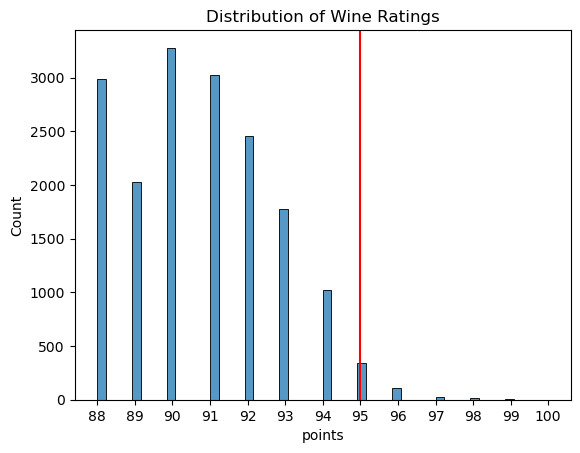

In [19]:
# Plot histogram of points in dataframe
ax = sns.histplot(df_wine_model, x='points')

plt.xticks(df_wine_model.points.unique())
plt.axvline(x=95, c='red')
plt.title('Distribution of Wine Ratings');

About 60% of the recommended wines have actual ratings above 95 points which signifies that the model is very good at recommending high quality and similar wines.

Now, we will access the top 10 recommendations provided by the model if a new user wants to choose a wine with specific traits like `cherry` or `pencil_lead`.

In [20]:
# Return the top10 recommended wines when a new user chooses wine with either cherry or pencil lead
# Create df that merge estimated ratings with full wine details df
df_wine_rec = df_wine_model.merge(recommend_df, on='title', how='inner')

# Create df which consists of wines fulfiling either traits
df_temp_traits = df_wine_combi.drop(columns=['taster_name', 'points', 'variety', 'designation', 'winery', 'country', 'province', 'region_1', 'region_2', 'price', 'description',
                                             'desc_wd_count', 'traits'])
trait_filter = ['title', 'cherry', 'pencil_lead']
df_temp_traits = df_temp_traits[trait_filter]
df_temp_traits['sum'] = df_temp_traits.sum(axis = 1, numeric_only=True)
df_temp_traits = df_temp_traits[df_temp_traits['sum'] != 0]

# Merge both dfs and show the top 10 by estimated ratings
df_recommend_details = df_temp_traits.merge(df_wine_rec, on='title', how='left')
df_recommend_final = df_recommend_details.sort_values('est_match_pts', ascending=False).drop_duplicates()
df_recommend_final[['title', 'est_match_pts', 'points']].head(10)

,title,est_match_pts,points
3797,Alpha Omega 2012 ERA Red (Napa Valley),91.448946,99
3589,Williams Selyem 2012 Eastside Road Neighbors Pinot Noir (Russian River Valley),91.397192,95
1501,Cayuse 2011 En Cerise Vineyard Syrah (Walla Walla Valley (OR)),91.375636,98
3798,Alpha Omega 2012 Beckstoffer Missouri Hopper Cabernet Sauvignon (Oakville),91.358037,98
3588,Williams Selyem 2013 Westside Road Neighbors Pinot Noir (Russian River Valley),91.358037,98
852,Shafer 2012 Hillside Select Cabernet Sauvignon (Stags Leap District),91.358037,98
491,Freeman 2012 Gloria Estate Pinot Noir (Russian River Valley),91.334430,94
1502,Wayfarer 2012 The Traveler Pinot Noir (Fort Ross-Seaview),91.267128,97
1424,Cobb 2012 Diane Cobb Coastlands Vineyard Pinot Noir (Sonoma Coast),91.267128,97
3752,Donkey & Goat 2010 Fenaughty Vineyard Syrah (El Dorado),91.267128,97


80% of the recommended wines have actual ratings above 95 points which signifies that the model is very good at recommending high quality wines.

## Model Evaluation

Model|Root Mean Squared Error (RMSE)|Precision@k
---|---|---
Pure Randomized Recommender (Baseline)|n/a|0.36
**KNN Baseline (Tuned)**|**1.828586**|**0.751706**
Baseline Predictor|1.921808|0.751706
KNN Basic|1.853119|0.751706
KNN Means|1.853373|0.751706
KNN ZScore|1.853372|0.751706
KNN Baseline|1.828589|0.751706
Slope One|1.853719|0.751706
Co-clustering|1.858452|0.749706
SVD|1.830108|0.659683
Normal Predictor|2.67958|0.605464
NonNegative Matrix Factorization|2.123324|0.582563

From the table above, the baseline model performed very poorly. With high volatility in its RMSE, the differences in its predicted rating to the actual rating for each taster-wine pair can fluctuate exponentially. It also has the lowest Precision@k score, which means it performs poorly in recommending the relevant wines in its top 10 recommendations.

The tuned k-NN Baseline with k=35 and cosine similarity measure performed the best out of all the models. Even though its Precision@k score is the same as six other models, it has the lowest RMSE score thus far. Thus, this model is very good at recommending relevant wines in its top 10 recommendations. Its predicted ratings are also much closer to the actual ratings for each taster-wine pair with a known label, compared to other models.

## Conclusion

**Recommendation System Model**

[k-NN Baseline](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline) is the most suitable model to use for recommending wines. This model is capable of suggesting good quality wines better than leaving the recommendations by chance.<br>
Reasons are stated below:
1. Precision@k score is above 0.75 and higher than that of other models.
2. RMSE score is lowest amongst all other models.

**Limitation/Further Improvements**

A limitation of k-NN algorithm models is that they cannot handle higher dimensional data well. It implies that if the number of users or number of wines in the database increase, the chosen model might not perform well and end up giving poor recommendations. This leads to scalability issues for the client if they want to update the database.<br>

Our model is limited to the dataset used to train the recommender system. This is because the model can't recommend wines that are not available in the actual database in the first place. To add on, it is limited by the user reviews recorded in the dataset and any new users would not be able to update their actual ratings in the dataset. It would be good to update the ratings of new users in the database and retrain the recommender system from time to time. That way, our recommender system can stay relevant and continue to give good recommendations going forward. The recommender system can be further enhanced to exclude wines that have gone out of stock by linking the inventory data back to the dataset used by the recommender.

## Recommendation

Going back to the problem statement, we recommend that the k-NN Baseline model should be used as a recommender system to suggest suitable wines to customers.

*Please proceed to the Streamlit app version of this wine recommender to try it out for yourself*